In [1]:
import os
import warnings

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime
from sklearn.metrics import mean_absolute_error

In [4]:
from lightautoml.tasks import Task
from lightautoml.addons.autots.base import AutoTS
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_cb import BoostCB
from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
from lightautoml.pipelines.features.lgb_pipeline import LGBSeqSimpleFeatures
from lightautoml.pipelines.features.linear_pipeline import LinearTrendFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.reader.base import DictToPandasSeqReader
from lightautoml.automl.blend import WeightedBlender
from lightautoml.ml_algo.random_forest import RandomForestSklearn

In [5]:
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_parquet("../../../data/interim/Московская область/peak_hours.gzip")

In [7]:
df.head(3)

,date,peak_hour,code_dpg
0,2012-04-02,11,PBALEST1
1,2012-04-03,11,PBALEST1
2,2012-04-04,11,PBALEST1


In [8]:
HORIZON = 31
TARGET_COLUMN = "peak_hour"
DATE_COLUMN = "date"

In [9]:
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN])
df.head(3)

,date,peak_hour,code_dpg
0,2012-04-02,11,PBALEST1
1,2012-04-03,11,PBALEST1
2,2012-04-04,11,PBALEST1


In [51]:
df

,date,peak_hour
29602,2024-07-01,14
29603,2024-07-02,15
29604,2024-07-03,15
29605,2024-07-04,14
29606,2024-07-05,14
29607,2024-07-08,16
29608,2024-07-09,16
29609,2024-07-10,16
29610,2024-07-11,15
29611,2024-07-12,14


<Axes: xlabel='date', ylabel='peak_hour'>

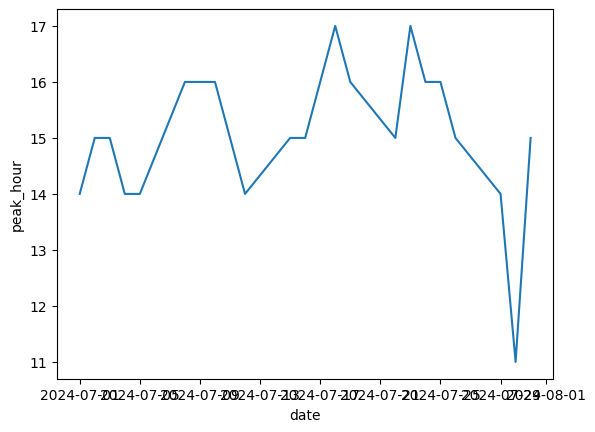

In [50]:
sns.lineplot(data=df, x="date", y="peak_hour")

In [10]:
df.drop(columns=["code_dpg"], inplace=True)

In [11]:
res = df.groupby(pd.Grouper(key="date", axis=0, freq="1D", sort=True)).mean()

In [12]:
res.tail(3)

,peak_hour
date,
2024-07-29,14.0
2024-07-30,11.0
2024-07-31,15.0


In [13]:
# res.dropna(inplace=True)
res.fillna(res["peak_hour"].median(), inplace=True)

In [14]:
res.index

DatetimeIndex(['2012-04-02', '2012-04-03', '2012-04-04', '2012-04-05',
               '2012-04-06', '2012-04-07', '2012-04-08', '2012-04-09',
               '2012-04-10', '2012-04-11',
               ...
               '2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25',
               '2024-07-26', '2024-07-27', '2024-07-28', '2024-07-29',
               '2024-07-30', '2024-07-31'],
              dtype='datetime64[ns]', name='date', length=4504, freq='D')

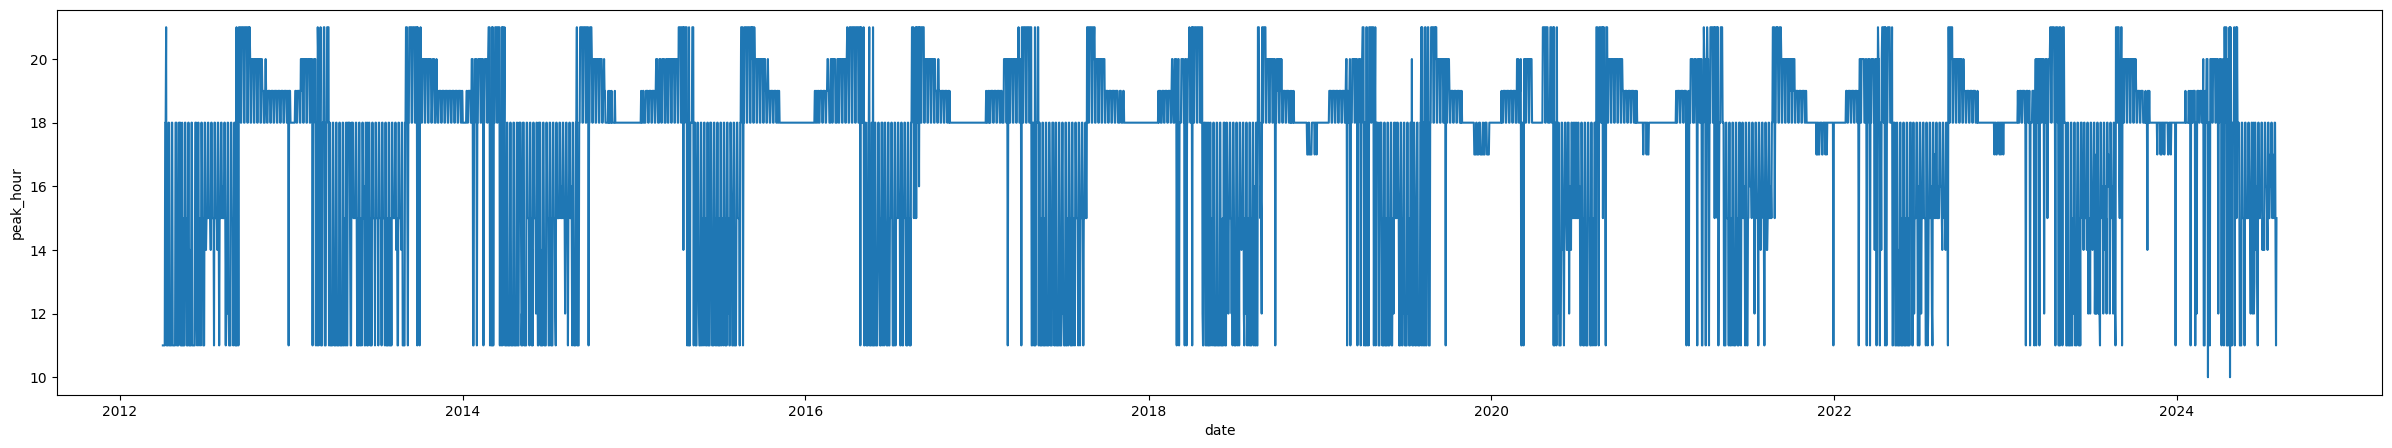

In [15]:
plt.figure(figsize=(30, 5))
sns.lineplot(data=res, x="date", y="peak_hour");

In [16]:
node = datetime(year=2024, month=7, day=1)

In [17]:
res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4504 entries, 2012-04-02 to 2024-07-31
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   peak_hour  4504 non-null   float64
dtypes: float64(1)
memory usage: 70.4 KB


In [18]:
res= res[res.index < node]

In [19]:
res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4473 entries, 2012-04-02 to 2024-06-30
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   peak_hour  4473 non-null   float64
dtypes: float64(1)
memory usage: 69.9 KB


In [20]:
res["date"] = res.index

In [21]:
res.reset_index(drop=True, inplace=True)

In [22]:
res.tail()

,peak_hour,date
4468,15.0,2024-06-26
4469,16.0,2024-06-27
4470,16.0,2024-06-28
4471,18.0,2024-06-29
4472,18.0,2024-06-30


In [23]:
test_start = res[DATE_COLUMN].values[-HORIZON]

train = res[res[DATE_COLUMN] < test_start].copy()
test = res[res[DATE_COLUMN] >= test_start].copy()

# CREATE MODEL

In [24]:
task = Task("multi:reg", greater_is_better=False, metric="mae", loss="mae")

multi:reg isn`t supported in lgb


In [25]:
univariate_roles = {
    "target": TARGET_COLUMN,
    DatetimeRole(seasonality=("d", "m", "wd"), base_date=True): DATE_COLUMN,
}

In [26]:
seq_params = {
    "seq0": {
        "case": "next_values",
        "params": {
            "n_target": HORIZON,
            "history": HORIZON,
            "step": 1,
            "from_last": True,
            "test_last": True
        }
    }
}

In [27]:
transformers_params = {
    "lag_features": 30,
    "lag_time_features": 30,
    "diff_features": [1, 2, 3, 4, 5, 6, 7, 14],
}

In [28]:
automl = AutoTS(
    task,
    reader_params = {
        "seq_params": seq_params
    },
    time_series_trend_params={
        "trend": False,
    },
    time_series_pipeline_params=transformers_params
)

In [29]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [30]:
univariate_train = train
univariate_test = test

In [31]:
univariate_train.sort_index(axis=1, inplace=True)
univariate_test.sort_index(axis=1, inplace=True)

In [32]:
univariate_test.head(3)

,date,peak_hour
4442,2024-05-31,15.0
4443,2024-06-01,18.0
4444,2024-06-02,18.0


In [33]:
univariate_train.head(3)

,date,peak_hour
0,2012-04-02,11.0
1,2012-04-03,11.0
2,2012-04-04,11.0


In [34]:
univariate_train

,date,peak_hour
0,2012-04-02,11.0
1,2012-04-03,11.0
2,2012-04-04,11.0
3,2012-04-05,11.0
4,2012-04-06,11.0
...,...,...
4437,2024-05-26,18.0
4438,2024-05-27,15.0
4439,2024-05-28,15.0
4440,2024-05-29,15.0


In [35]:
univariate_train_pred, _ = automl.fit_predict(univariate_train, univariate_roles, verbose=4)

[14:38:46] Stdout logging level is DEBUG.
[14:38:46] Task: multi:reg

[14:38:46] Start automl preset with listed constraints:
[14:38:46] - time: 3600.00 seconds
[14:38:46] - CPU: 4 cores
[14:38:46] - memory: 16 GB

[14:38:46] Layer 1 train process start. Time left 3599.95 secs
[14:38:46] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[14:38:46] Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 32, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'verbose': 0, 'criterion': 'squared_error'}
[14:38:46] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[14:38:48] Score for RF model: -1.335110
[14:38:48] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[14:38:49] Score for RF model: -1.263419
[14:38:49] Fitting Lvl_0_Pipe_0_Mod_0_RFSkle

In [36]:
univariate_test

,date,peak_hour
4442,2024-05-31,15.0
4443,2024-06-01,18.0
4444,2024-06-02,18.0
4445,2024-06-03,15.0
4446,2024-06-04,16.0
4447,2024-06-05,14.0
4448,2024-06-06,12.0
4449,2024-06-07,16.0
4450,2024-06-08,18.0
4451,2024-06-09,18.0


In [37]:
univariate_forecast, _ = automl.predict(univariate_train)

In [38]:
pred = [round(day) for day in univariate_forecast]

In [47]:
pred

[13,
 17,
 18,
 14,
 13,
 13,
 13,
 13,
 17,
 18,
 14,
 14,
 14,
 14,
 13,
 17,
 17,
 14,
 14,
 14,
 14,
 13,
 17,
 18,
 15,
 14,
 14,
 14,
 13,
 17,
 17]

In [39]:
df = pd.read_parquet("../../../data/interim/Московская область/peak_hours.gzip")

In [40]:
df.drop(columns=["code_dpg"], inplace=True)

In [41]:
df["date"] = pd.to_datetime(df["date"])

In [42]:
df = df[df["date"] >= node]

In [43]:
df.drop_duplicates(inplace=True)

In [44]:
df

,date,peak_hour
29602,2024-07-01,14
29603,2024-07-02,15
29604,2024-07-03,15
29605,2024-07-04,14
29606,2024-07-05,14
29607,2024-07-08,16
29608,2024-07-09,16
29609,2024-07-10,16
29610,2024-07-11,15
29611,2024-07-12,14


In [45]:
len(pred)

31

In [46]:
print(univariate_forecast, "\n")
print(f"MAE: {mean_absolute_error(univariate_test.value, univariate_forecast)}")

[12.64168549 17.46391487 17.72834778 13.95302391 12.99095917 13.20945072
 13.21040821 12.77117729 17.05090141 17.59422684 14.19304276 13.53090572
 13.90925312 13.98851299 12.94319725 17.3168335  17.43126297 14.38192844
 13.63861847 13.89741135 14.05263996 13.24490356 17.19371033 17.63647079
 14.66446781 13.86149311 13.51597977 13.62025738 12.98931026 17.16523552
 17.33032227] 



AttributeError: 'DataFrame' object has no attribute 'value'